### Preliminaries

This example shows both the use of individual transformers and the `TimeSeriesFeatures` convenience class that wraps multiple transformers. Both methods are compatible with Scikit-Learn `Pipeline` objects.

It uses the Macrodata dataset from `Statsmodels`, which includes quarterly US Macroeconomic Data from 1950 through 2009.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.datasets
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from steps.forward import ForwardSelector

from tsfeast.transformers import DateTimeFeatures, InteractionFeatures, LagFeatures
from tsfeast.tsfeatures import TimeSeriesFeatures
from tsfeast.funcs import get_datetime_features
from tsfeast.utils import plot_diag

In [2]:
def make_dummy_data(n=200):
    coefs = {'ar': [1, 0.75], 'ma': [1], 'trend': 3.2, 'bdays_in_month': 231, 'marketing': 0.002}
    rng = np.random.default_rng(seed=42)
    
    sales = pd.DataFrame({
        'date': pd.date_range(end='2020-08-31', periods=200, freq='M'),
        'base': rng.poisson(1000, n),
        'ar': arma_generate_sample(ar=coefs['ar'], ma=coefs['ma'], nsample=n, scale=400),
        'trend': [x * coefs['trend'] + rng.poisson(100) for x in range(n)],
    })
    sales = sales.join(get_datetime_features(sales['date']))
    sales['per_day'] = sales['bdays_in_month'] * coefs['bdays_in_month'] + rng.poisson(100, n)
    sales['mkt_base'] = rng.normal(1e6, 1e4, n)
    sales['mkt_trend'] = [x * 5e3 for x in range(1, n+1)]
    sales['mkt_season'] = np.where(sales['quarter'] == 3, sales['mkt_base'] * .30, 0)
    sales['mkt_total'] = sales.loc[:, 'mkt_base': 'mkt_season'].sum(1)
    
    return pd.DataFrame({
        'y': sales.loc[:, 'base':'trend'].sum(1) + (sales['mkt_total'].shift(2) * coefs['marketing'] + rng.poisson(100, n)),
        'date': sales['date'],
        'marketing': sales['mkt_total']
    })

In [3]:
data = make_dummy_data().dropna()

/Users/christophersantiago/Dropbox/Programming/tsfeast/tsfeast/funcs.py:77: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dt_features['week'] = X_dt.week  # pylint: disable=no-member


The only pre-processing necessary is to combined the separate `year` and `quarter` columns into a single `date` column:

In [4]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
x_train, x_test = X.iloc[:-40, :], X.iloc[-40:, :]
y_train, y_test = y.iloc[:-40], y.iloc[-40:]

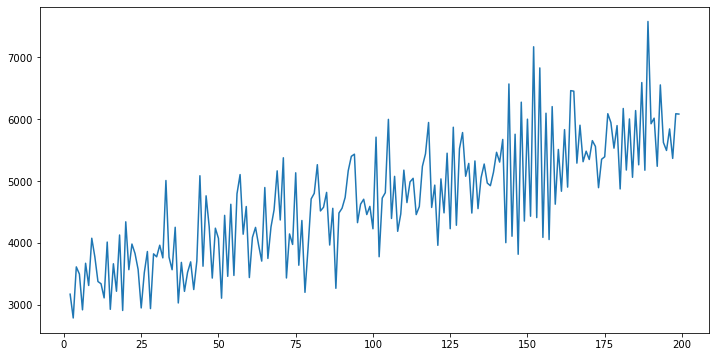

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.show()

### Individual Transformers

#### Generate DateTime Features

In [6]:
dt = DateTimeFeatures(date_col='date')
dt.fit_transform(X, y)

Calling fit method with M frequency.


/Users/christophersantiago/Dropbox/Programming/tsfeast/tsfeast/funcs.py:77: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dt_features['week'] = X_dt.week  # pylint: disable=no-member


,year,quarter,month,week,weekday,days_in_month,bdays_in_month,leap_year
2,2004,1,3,14,2,31,23,1
3,2004,2,4,18,4,30,22,1
4,2004,2,5,23,0,31,20,1
5,2004,2,6,27,2,30,22,1
6,2004,3,7,31,5,31,21,1
...,...,...,...,...,...,...,...,...
195,2020,2,4,18,3,30,22,1
196,2020,2,5,22,6,31,20,1
197,2020,2,6,27,1,30,22,1
198,2020,3,7,31,4,31,22,1


#### Generate Interaction Features

In [7]:
feat = LagFeatures(n_lags=4)
feat.fit_transform(X.iloc[:, 1:], y)

,marketing_lag_1,marketing_lag_2,marketing_lag_3,marketing_lag_4
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1.011203e+06,0.000000e+00,0.000000e+00,0.000000e+00
4,1.023769e+06,1.011203e+06,0.000000e+00,0.000000e+00
5,1.013730e+06,1.023769e+06,1.011203e+06,0.000000e+00
6,1.043286e+06,1.013730e+06,1.023769e+06,1.011203e+06
...,...,...,...,...
195,1.967714e+06,1.963716e+06,1.951241e+06,1.956345e+06
196,1.987715e+06,1.967714e+06,1.963716e+06,1.951241e+06
197,1.993091e+06,1.987715e+06,1.967714e+06,1.963716e+06
198,1.988542e+06,1.993091e+06,1.987715e+06,1.967714e+06


### TimeSeriesFeatures Class


In [8]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=4,
    interactions=False,
    polynomial=3
)
features = feat.fit_transform(X, y)

Calling fit method with M frequency.


/Users/christophersantiago/Dropbox/Programming/tsfeast/tsfeast/funcs.py:77: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dt_features['week'] = X_dt.week  # pylint: disable=no-member
/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [9]:
features.head()

,trend,original__marketing,datetime__year,datetime__quarter,datetime__month,datetime__week,datetime__weekday,datetime__days_in_month,datetime__bdays_in_month,datetime__leap_year,features__lags__marketing_lag_1,features__lags__marketing_lag_2,features__lags__marketing_lag_3,features__lags__marketing_lag_4,features__polynomial__marketing^2,features__polynomial__marketing^3
0,1.0,1.011203e+06,2004.0,1.0,3.0,14.0,2.0,31.0,23.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.022532e+12,1.033987e+18
1,2.0,1.023769e+06,2004.0,2.0,4.0,18.0,4.0,30.0,22.0,1.0,1.011203e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.048104e+12,1.073017e+18
2,3.0,1.013730e+06,2004.0,2.0,5.0,23.0,0.0,31.0,20.0,1.0,1.023769e+06,1.011203e+06,0.000000e+00,0.000000e+00,1.027649e+12,1.041758e+18
3,4.0,1.043286e+06,2004.0,2.0,6.0,27.0,2.0,30.0,22.0,1.0,1.013730e+06,1.023769e+06,1.011203e+06,0.000000e+00,1.088446e+12,1.135561e+18
4,5.0,1.351193e+06,2004.0,3.0,7.0,31.0,5.0,31.0,21.0,1.0,1.043286e+06,1.013730e+06,1.023769e+06,1.011203e+06,1.825723e+12,2.466905e+18


In [10]:
[x for x in features.columns]

['trend',
 'original__marketing',
 'datetime__year',
 'datetime__quarter',
 'datetime__month',
 'datetime__week',
 'datetime__weekday',
 'datetime__days_in_month',
 'datetime__bdays_in_month',
 'datetime__leap_year',
 'features__lags__marketing_lag_1',
 'features__lags__marketing_lag_2',
 'features__lags__marketing_lag_3',
 'features__lags__marketing_lag_4',
 'features__polynomial__marketing^2',
 'features__polynomial__marketing^3']

In [36]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=4,
    interactions=False
)

pl = Pipeline([
    ('feature_extraction', feat),
    ('feature_selection', ForwardSelector()),
    ('regression', LinearRegression())
])

pl.fit(x_train, y_train)

Calling fit method with M frequency.


/Users/christophersantiago/Dropbox/Programming/tsfeast/tsfeast/funcs.py:77: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dt_features['week'] = X_dt.week  # pylint: disable=no-member
/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Pipeline(steps=[('feature_extraction',
                 TimeSeriesFeatures(datetime='date', interactions=False, lags=4,
                                    trend='t')),
                ('feature_selection', ForwardSelector()),
                ('regression', LinearRegression())])

In [37]:
pl.named_steps.feature_extraction.transform(x_train)

Calling fit method with None frequency.


/Users/christophersantiago/Dropbox/Programming/tsfeast/tsfeast/funcs.py:77: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dt_features['week'] = X_dt.week  # pylint: disable=no-member
/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,trend,original__marketing,datetime__year,datetime__quarter,datetime__month,datetime__week,datetime__weekday,datetime__days_in_month,datetime__bdays_in_month,datetime__leap_year,features__lags__marketing_lag_1,features__lags__marketing_lag_2,features__lags__marketing_lag_3,features__lags__marketing_lag_4
158,159.0,1.011203e+06,2004.0,1.0,3.0,14.0,2.0,31.0,23.0,1.0,1.772503e+06,1.782320e+06,1.770655e+06,1.781848e+06
159,160.0,1.023769e+06,2004.0,2.0,4.0,18.0,4.0,30.0,22.0,1.0,1.011203e+06,1.772503e+06,1.782320e+06,1.770655e+06
160,161.0,1.013730e+06,2004.0,2.0,5.0,23.0,0.0,31.0,20.0,1.0,1.023769e+06,1.011203e+06,1.772503e+06,1.782320e+06
161,162.0,1.043286e+06,2004.0,2.0,6.0,27.0,2.0,30.0,22.0,1.0,1.013730e+06,1.023769e+06,1.011203e+06,1.772503e+06
162,163.0,1.351193e+06,2004.0,3.0,7.0,31.0,5.0,31.0,21.0,1.0,1.043286e+06,1.013730e+06,1.023769e+06,1.011203e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,312.0,1.793120e+06,2016.0,4.0,12.0,52.0,5.0,31.0,21.0,1.0,1.767851e+06,1.772103e+06,2.043130e+06,2.034033e+06
312,313.0,1.781848e+06,2017.0,1.0,1.0,5.0,1.0,31.0,20.0,0.0,1.793120e+06,1.767851e+06,1.772103e+06,2.043130e+06
313,314.0,1.770655e+06,2017.0,1.0,2.0,9.0,1.0,28.0,19.0,0.0,1.781848e+06,1.793120e+06,1.767851e+06,1.772103e+06
314,315.0,1.782320e+06,2017.0,1.0,3.0,13.0,4.0,31.0,23.0,0.0,1.770655e+06,1.781848e+06,1.793120e+06,1.767851e+06


In [38]:
mean_squared_error(y_test, pl.predict(x_test))

Calling fit method with M frequency.


/Users/christophersantiago/Dropbox/Programming/tsfeast/tsfeast/funcs.py:77: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dt_features['week'] = X_dt.week  # pylint: disable=no-member
/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


251650.37468457496

In [39]:
new_features = pl.named_steps.feature_extraction.feature_names_
mask = pl.named_steps.feature_selection.get_support()
new_features[mask]

Index(['trend', 'datetime__days_in_month', 'features__lags__marketing_lag_2',
       'features__lags__marketing_lag_4'],
      dtype='object')

In [40]:
lr = LinearRegression()
lr.fit(X.iloc[:, 1:], y)
lr.score(X.iloc[:, 1:], y)

0.5209811094153634

/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


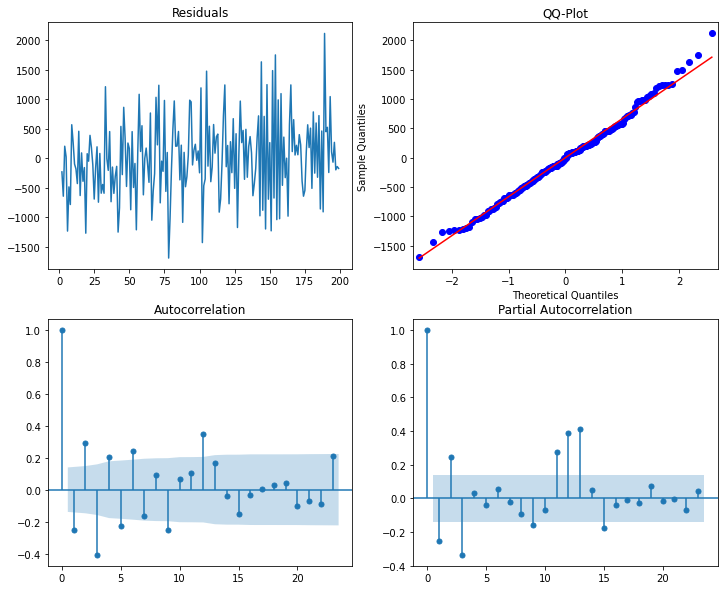

In [41]:
plot_diag(lr, X.iloc[:, 1:], y)